In [1]:


import sys;
import torch;
import torch.nn as nn;
import torchtext.data as ttd;
from torchtext.vocab import GloVe;

import numpy as np;
import matplotlib.pyplot as plt;
import pandas as pd;
pd.options.mode.chained_assignment = None; ## avoid warning
#from datetime import datetime;
import time;
## time.process_time() to record the time

import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/My Drive/Code Colab/Torch_Tools";
os.chdir(path);
os.listdir(path);

from YZ_torch_tools import YZ_nn_model;
from YZ_torch_tools import YZ_nn_layer;
from YZ_torch_tools import YZ_nn_optimize;

path = "/content/drive/My Drive/Code Colab/Sentiment analysis/CNN";
os.chdir(path);
os.listdir(path);

Mounted at /content/drive


In [2]:
TEXT = ttd.Field(
    sequential = True,
    batch_first = True,
    lower = True,
    #tokenize = 'spacy',
    pad_first = True
)
LABEL = ttd.Field(sequential = False, use_vocab = False, is_target = True);
dataset = ttd.TabularDataset(path = 'twitter.csv', format = 'csv',
                             skip_header = True,
                             fields = [('label', LABEL),('data', TEXT)] 
                             ## it will generate an obj dattset.example.data
                             ## and an obj dattset.example.label
                             );

train_dataset, test_dataset = dataset.split(0.7);## default 0.7 here
TEXT.build_vocab(train_dataset);
vocab = TEXT.vocab;
print(len(vocab));
#vocab.stoi
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
print(device);

K_class = 3;

20101
cuda:0


In [3]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data), ## x is this object
    batch_sizes = (32,1000),
    device = device
    );
print(len(train_dataset));
print(len(test_dataset))
printlist = [0,1,2,3,4,10,20,30,40];
ind = 0;
for inputs, targets in train_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind)

ind = 0;
for inputs, targets in test_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind)

9710
4161
0 torch.Size([32, 25])
1 torch.Size([32, 25])
2 torch.Size([32, 23])
3 torch.Size([32, 24])
4 torch.Size([32, 24])
10 torch.Size([32, 26])
20 torch.Size([32, 22])
30 torch.Size([32, 24])
40 torch.Size([32, 25])
304
0 torch.Size([1000, 12])
1 torch.Size([1000, 16])
2 torch.Size([1000, 19])
3 torch.Size([1000, 24])
4 torch.Size([161, 29])
5


## LSTM model!

In [0]:
class nn_LSTM(nn.Module):
    def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, device):
        super(nn_LSTM,self).__init__();
        self.V = n_vocab;
        self.D = embed_dim;
        self.M = n_hidden;
        self.K = n_outputs;
        self.L = n_rnnlayers;

        self.device = device;

        self.embed = nn.Embedding(self.V, self.D);
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M,
            num_layers = self.L,
            batch_first = True,
            dropout = 0.25
        );

        self.drop = nn.Dropout(0.25);

        self.softmax = nn.Softmax(dim=1);
        self.fc = nn.Linear(self.M,self.K);

    def forward(self, X):
        ## init hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device);
        c0 = torch.zeros(self.L, X.size(0), self.M).to(self.device);
        #h0 = torch.zeros(self.L, X.size(0), self.M);
        #c0 = torch.zeros(self.L, X.size(0), self.M);

        ## embedding layer
        ## words index 2 into word vectors
        out = self.embed(X);

        ## get rnn unit output
        out,_ = self.rnn(out, (h0,c0));

        ## max pool
        out,_ = torch.max(out,1);
        ## we only need h(T) finally

        out = self.drop(out);
        out = self.fc(out);
        #out = self.softmax(out);
        return out;

Doing a classification with 3 label(s)!


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch (1 / 6)...Train_Loss: 5.732e-01...Test_loss: 5.489e-01...Duration: 1.209e+00 sec
Epoch (2 / 6)...Train_Loss: 5.392e-01...Test_loss: 5.280e-01...Duration: 2.392e+00 sec
Epoch (3 / 6)...Train_Loss: 5.141e-01...Test_loss: 5.164e-01...Duration: 3.559e+00 sec
Epoch (4 / 6)...Train_Loss: 4.864e-01...Test_loss: 5.035e-01...Duration: 4.721e+00 sec
Epoch (5 / 6)...Train_Loss: 4.588e-01...Test_loss: 4.999e-01...Duration: 5.890e+00 sec
Epoch (6 / 6)...Train_Loss: 4.312e-01...Test_loss: 4.994e-01...Duration: 7.054e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!

**********************************************************
Training:
The classification rate for this dataset is 70.7%
Testing:
The classification rate for this dataset is 63.0%
**********************************************************


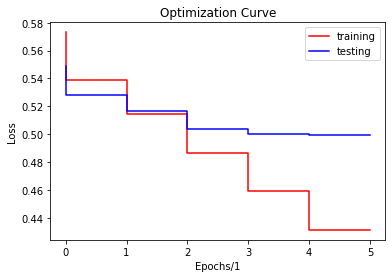

In [5]:
lr = 1e-3;

V = len(vocab);
D = 50;
M = 12;
L = 1;

model = nn_LSTM(V,D,  M, L ,K_class, device);
model.to(device);
criterion = nn.BCEWithLogitsLoss(); ## Python can even return a function
optimizer = torch.optim.Adam(model.parameters(),lr=lr);

YZ_train = YZ_nn_optimize(model,train_iter, test_iter, device = device, K_class = K_class);
YZ_train.Optimizing(lr, criterion, optimizer, epochs = 6, plot_epoch = 1);

## Try my own pk

In [6]:
train_iter, test_iter = ttd.Iterator.splits(
    (train_dataset, test_dataset), 
    sort_key = lambda x: len(x.data), ## x is this object
    batch_sizes = (32,1000),
    device = device
    );
print(len(train_dataset));
print(len(test_dataset))
printlist = [0,1,2,3,4,10,20,30,40];
ind = 0;
for inputs, targets in train_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind)

ind = 0;
for inputs, targets in test_iter:
    #print(inputs,'\n',targets);
    #break;
    if ind in printlist:
        print(ind, inputs.shape);
    ind += 1;
print(ind)



9710
4161
0 torch.Size([32, 25])
1 torch.Size([32, 25])
2 torch.Size([32, 23])
3 torch.Size([32, 24])
4 torch.Size([32, 24])
10 torch.Size([32, 26])
20 torch.Size([32, 22])
30 torch.Size([32, 24])
40 torch.Size([32, 25])
304
0 torch.Size([1000, 12])
1 torch.Size([1000, 16])
2 torch.Size([1000, 19])
3 torch.Size([1000, 24])
4 torch.Size([161, 29])
5


In [7]:
lr = 1e-3;
V = len(vocab);
D = 50;
M = 12;
L = 1;
out_seq1 =  [2,nn.LSTM(
            input_size = D,
            hidden_size = M,
            num_layers = L,
            batch_first = True, dropout =0.25
            )];

LD = YZ_nn_layer(V);
#Embed_layer = [["Embedding", D]];
#LD.YZ_nn_sequential(Embed_layer);
#LD.Insert_Seq(out_seq1, D, M);
#full_layer = [["Dropout",0.25],["Torch_max",1],["Linear",K_class]];
#LD.YZ_nn_sequential(full_layer);
LD.Insert_Seq([1,nn_LSTM(V,D,  M, L ,K_class, device)],V, K_class)
#LD.Insert_Seq(nn_LSTM(V,D,  M, L ,K_class, device),V, K_class)
LD.Show();

[['YIZHOU_layer', Sequential(
  (0): Costum_module_mono_out(
    (mod): nn_LSTM(
      (embed): Embedding(20101, 50)
      (rnn): LSTM(50, 12, batch_first=True, dropout=0.25)
      (drop): Dropout(p=0.25, inplace=False)
      (softmax): Softmax(dim=1)
      (fc): Linear(in_features=12, out_features=3, bias=True)
    )
  )
)]]


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Doing a classification with 3 label(s)!
Epoch (1 / 6)...Train_Loss: 5.829e-01...Test_loss: 5.532e-01...Duration: 1.205e+00 sec
Epoch (2 / 6)...Train_Loss: 5.492e-01...Test_loss: 5.368e-01...Duration: 2.354e+00 sec
Epoch (3 / 6)...Train_Loss: 5.220e-01...Test_loss: 5.129e-01...Duration: 3.521e+00 sec
Epoch (4 / 6)...Train_Loss: 4.821e-01...Test_loss: 5.053e-01...Duration: 4.712e+00 sec
Epoch (5 / 6)...Train_Loss: 4.467e-01...Test_loss: 4.973e-01...Duration: 5.885e+00 sec
Epoch (6 / 6)...Train_Loss: 4.179e-01...Test_loss: 5.069e-01...Duration: 7.056e+00 sec
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!
Yizhou said 欲速则不达，施主稍安勿躁: | ▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒▒ | 100.0% (^_^)/ Done!

**********************************************************
Training:
The classification rate for this dataset is 73.3%
Testing:
The classification rate for this dataset is 63.4%
*********************************************************

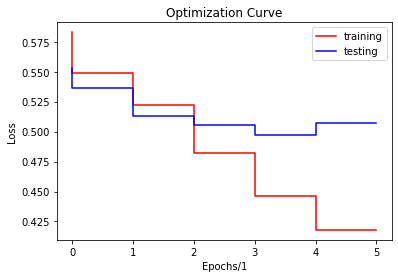

In [8]:
YZ_model = YZ_nn_model(LD.Seq);

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu");
criterion = nn.BCEWithLogitsLoss(); ## Python can even return a function
optimizer = torch.optim.Adam(YZ_model.parameters(),lr=lr);

YZ_train2 = YZ_nn_optimize(YZ_model, train_iter, test_iter, device = False, K_class = K_class);
YZ_train2.Optimizing(lr=lr, criterion = criterion, optimizer = False, epochs = 6, plot_epoch = 1);


In [9]:
LD.Show()

[['YIZHOU_layer', Sequential(
  (0): Costum_module_mono_out(
    (mod): nn_LSTM(
      (embed): Embedding(20101, 50)
      (rnn): LSTM(50, 12, batch_first=True, dropout=0.25)
      (drop): Dropout(p=0.25, inplace=False)
      (softmax): Softmax(dim=1)
      (fc): Linear(in_features=12, out_features=3, bias=True)
    )
  )
)]]


In [10]:
YZ_model

YZ_nn_model(
  (layers): ModuleList(
    (0): Sequential(
      (0): Costum_module_mono_out(
        (mod): nn_LSTM(
          (embed): Embedding(20101, 50)
          (rnn): LSTM(50, 12, batch_first=True, dropout=0.25)
          (drop): Dropout(p=0.25, inplace=False)
          (softmax): Softmax(dim=1)
          (fc): Linear(in_features=12, out_features=3, bias=True)
        )
      )
    )
  )
)

In [11]:
model

nn_LSTM(
  (embed): Embedding(20101, 50)
  (rnn): LSTM(50, 12, batch_first=True, dropout=0.25)
  (drop): Dropout(p=0.25, inplace=False)
  (softmax): Softmax(dim=1)
  (fc): Linear(in_features=12, out_features=3, bias=True)
)